# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [77]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.tail()

,attribute,information_level,type,missing_or_unknown
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


In [11]:
feat_info.shape

(85, 4)

In [12]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [13]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,TITEL_KZ,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [14]:
# Identify missing or unknown data values and convert them to NaNs.

azdias.isnull().sum().sum()

4896838

In [15]:
#Check the values of the 'missing_or_unknown' column before parsing
for i in range(len(feat_info)):
    missing_unknown = feat_info.iloc[i]['missing_or_unknown']
    print(missing_unknown)

[-1,0]
[-1,0,9]
[-1,0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[0]
[]
[]
[-1,0]
[0]
[0]
[0]
[0]
[0]
[0]
[-1,0]
[-1,0]
[0]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1]
[-1]
[-1,0]
[-1]
[-1,9]
[0]
[]
[]
[-1,0]
[-1]
[-1,0]
[-1,0]
[0]
[]
[-1,0]
[]
[0]
[-1]
[-1]
[-1,X]
[XX]
[-1,XX]
[-1]
[-1]
[-1]
[-1]
[-1,0]
[-1,0]
[-1]
[-1]
[-1]
[]
[-1,0]
[]
[]
[-1,0]
[]
[-1]
[-1]
[-1]
[-1]
[-1,0]
[-1]
[-1]
[-1,9]
[-1,0]
[-1,9]


In [16]:
#Check the values of the 'missing_or_unknown' column after parsing
for i in range(len(feat_info)):
    missing_unknown = feat_info.iloc[i]['missing_or_unknown']
    missing_unknown = missing_unknown.strip('[').strip(']').split(sep=',')
    print(missing_unknown)

['-1', '0']
['-1', '0', '9']
['-1', '0']
['0']
['-1']
['-1']
['-1']
['-1']
['-1']
['-1']
['-1']
['0']
['']
['']
['-1', '0']
['0']
['0']
['0']
['0']
['0']
['0']
['-1', '0']
['-1', '0']
['0']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1']
['-1']
['-1', '0']
['-1']
['-1', '9']
['0']
['']
['']
['-1', '0']
['-1']
['-1', '0']
['-1', '0']
['0']
['']
['-1', '0']
['']
['0']
['-1']
['-1']
['-1', 'X']
['XX']
['-1', 'XX']
['-1']
['-1']
['-1']
['-1']
['-1', '0']
['-1', '0']
['-1']
['-1']
['-1']
['']
['-1', '0']
['']
['']
['-1', '0']
['']
['-1']
['-1']
['-1']
['-1']
['-1', '0']
['-1']
['-1']
['-1', '9']
['-1', '0']
['-1', '9']


In [17]:
#Convert the missing values to NaN
for i in range(len(feat_info)):
    missing_unknown = feat_info.iloc[i]['missing_or_unknown']
    missing_unknown = missing_unknown.strip('[').strip(']').split(sep=',')
    missing_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_unknown]
    if missing_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_unknown}, np.nan)

In [18]:
azdias.isnull().sum().sum()

8373929

In [19]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_column = azdias.isnull().sum()
missing_data_column

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [21]:
missing_data_column_percent = missing_data_column / float(len(azdias)) * 100
missing_data_column_percent

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

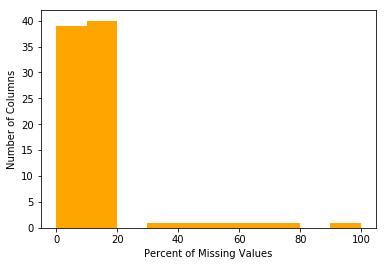

In [22]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data_column_percent, color = 'orange')
plt.xlabel("Percent of Missing Values")
plt.ylabel('Number of Columns')
plt.show()

In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers = missing_data_column_percent[missing_data_column_percent > 20]
outliers

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [24]:
remove_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
azdias = azdias.drop(remove_columns, axis = 1)

In [25]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [26]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [27]:
#dropping removed columns from feature info
feat_info_clean = feat_info[~feat_info['attribute'].isin(remove_columns)]

#### Discussion 1.1.2: Assess Missing Data in Each Column

Looking at the bar chart, the majority of the missing data was under 20%. Removing six columns cleaned up the data to assist in further analysis of the data. The columns which were removed were 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# How much data is missing in each row of the dataset?
missing_data_row = azdias.isnull().sum(axis=1)
missing_data_row.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

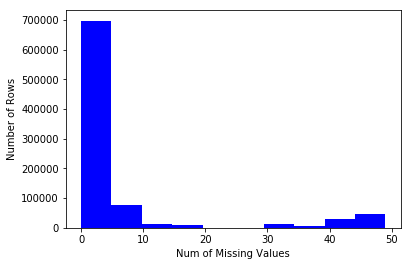

In [29]:
plt.hist(missing_data_row, color = 'blue')
plt.xlabel("Num of Missing Values")
plt.ylabel('Number of Rows')
plt.show()

In [30]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_data_below_30 = azdias[missing_data_row < 30]
missing_data_above_30 = azdias[missing_data_row >= 30]

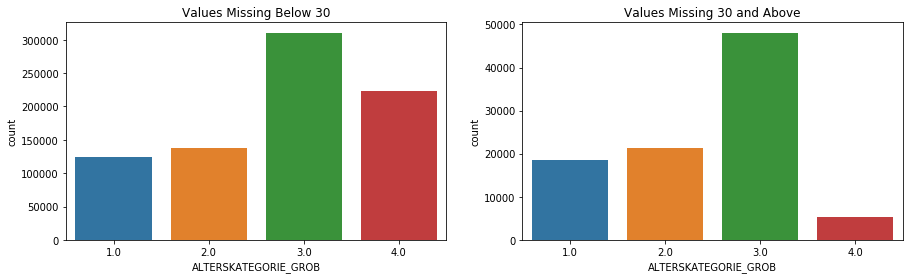

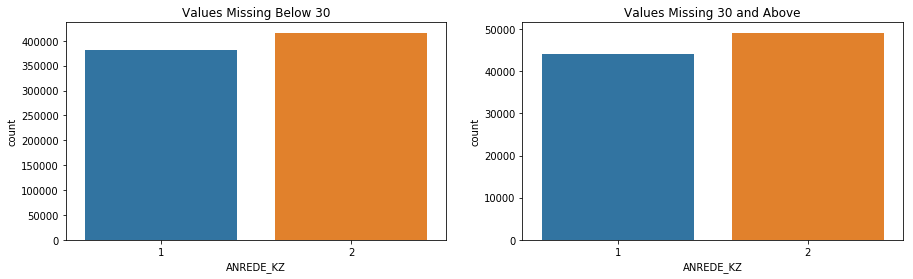

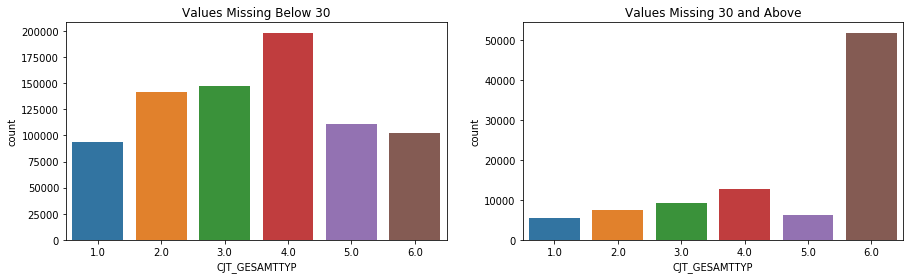

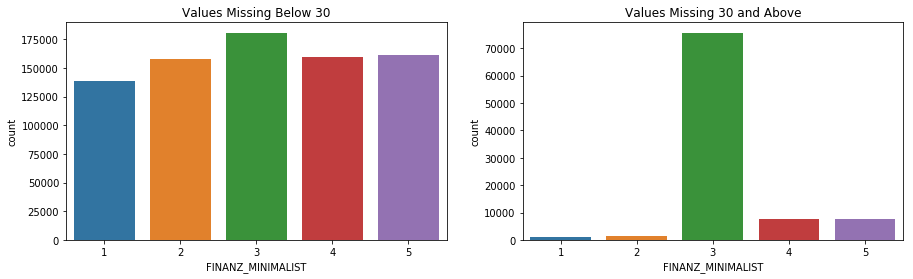

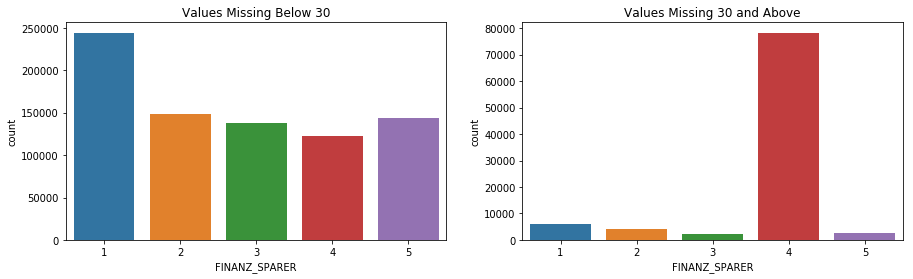

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
missing_data_columns = missing_data_below_30.columns[:5]
for i in range(missing_data_columns.size):
    fig, (axis1, axis2) = plt.subplots(1,2)
    fig.set_figwidth(15)
    
    axis1.set_title("Values Missing Below 30")
    sns.countplot(azdias.loc[missing_data_below_30.index, missing_data_columns[i]], ax = axis1)
    
    axis2.set_title('Values Missing 30 and Above')
    sns.countplot(azdias.loc[missing_data_above_30.index, missing_data_columns[i]], ax = axis2)
    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

After spliting the data at the 30 missing values mark, the majority of the missing values are in the 30 and above data. This makes the missing values below 30 more valuable to use as I go ahead with my analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [33]:
# How many features are there of each data type?
feat_info_clean.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = feat_info_clean[feat_info_clean.type == 'categorical']['attribute']

display(cat_features.head(21))
len(cat_features)

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

18

In [35]:
# Split the categorical features 
cat_binary = []
cat_multi = []

for i in cat_features:
    # check for multi categorical features
    try: 
        (missing_data_below_30[i].nunique() > 2)
        cat_binary.append(i)
    # check for binary categorical features
    except:
        cat_multi.append(i)
        
display(cat_binary)
display(cat_multi)

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

[]

In [36]:
#Dropping the multi-level categorical columns
missing_data_below_30.drop(cat_multi, axis = 1, inplace = True)
missing_data_below_30.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in cat_binary:
    print(missing_data_below_30[i].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
4.0    198295
3.0    147220
2.0    141269
5.0    111114
6.0    102107
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64
6    289061
1    197171
5    106332
2    104773
4     55922
3     44802
Name: FINANZTYP, dtype: int64
12.0    130261
10.0    102831
8.0      83030
11.0     75103
5.0      70501
4.0      60422
9.0      57131
3.0      53101
1.0      50659
2.0      43857
7.0      40681
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
1.0     402556
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402556
5.0    188172
2.0     98555
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206853
9.0     136353
10.0    111574
2.0     111118
4.0      73973
3.0      68918
6.0      28896
5.0      27592
8.0      18835
7.0    

In [38]:
#OST_WEST_KZ has letters instead of integers
missing_data_below_30.loc[:, 'OST_WEST_KZ'].replace({'W' : '0', 'O' : '1'}, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [39]:
#Check to see if it is fized
for i in cat_binary:
    print(missing_data_below_30[i].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
4.0    198295
3.0    147220
2.0    141269
5.0    111114
6.0    102107
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64
6    289061
1    197171
5    106332
2    104773
4     55922
3     44802
Name: FINANZTYP, dtype: int64
12.0    130261
10.0    102831
8.0      83030
11.0     75103
5.0      70501
4.0      60422
9.0      57131
3.0      53101
1.0      50659
2.0      43857
7.0      40681
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
1.0     402556
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402556
5.0    188172
2.0     98555
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206853
9.0     136353
10.0    111574
2.0     111118
4.0      73973
3.0      68918
6.0      28896
5.0      27592
8.0      18835
7.0    

#### Discussion 1.2.1: Re-Encode Categorical Features

I kept all categorical features except for the multi categorical features. The one categorical feature of OST_WEST_KZ had to be changed from letters to numbers to be a true binary categorical feature.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
missing_data_below_30[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


### Details from data_dictionary.md

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [41]:
#There are 6 different decades to choose from 1: 40s, 2: 50s, 3: 60s, 4: 70s, 5: 80s, and 6: 90s

decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 12:0, 13:1, 14:0, 15:1}

#Creating new columns in the azdias dataset
missing_data_below_30['DECADE'] = missing_data_below_30['PRAEGENDE_JUGENDJAHRE']
missing_data_below_30['DECADE'].replace(decade, inplace=True)

missing_data_below_30['MOVEMENT'] = missing_data_below_30['PRAEGENDE_JUGENDJAHRE']
missing_data_below_30['MOVEMENT'].replace(decade, inplace=True)

#Drop orignal unneeded column 
missing_data_below_30 = missing_data_below_30.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is

In [42]:
print(missing_data_below_30['DECADE'].head())
print(missing_data_below_30['MOVEMENT'].head())

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: DECADE, dtype: float64
1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: MOVEMENT, dtype: float64


In [43]:
missing_data_below_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,6.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,6.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,4.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,4.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,2.0


In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

missing_data_below_30[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54


### Details from data_dictionary.md

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [45]:
# Create wealth and life stage dictionaries   
wealth = {'11':1,'12':1,'13':1,'14':1,'15':1,
              '21':2,'22':2,'23':2,'24':2,'25':2,
              '31':3,'32':3,'33':3,'34':3,'35':3,
              '41':4,'42':4,'43':4,'44':4,'45':4,
              '51':5,'52':5,'53':5,'54':5,'55':5}

life_stage = {'11':1,'12':2,'13':3,'14':4,'15':5,
                  '21':1,'22':2,'23':3,'24':4,'25':5,
                  '31':1,'32':2,'33':3,'34':4,'35':5,
                  '41':1,'42':2,'43':3,'44':4,'45':5,
                  '51':1,'52':2,'53':3,'54':4,'55':5}

# Create wealth new column
missing_data_below_30['WEALTH'] = missing_data_below_30['CAMEO_INTL_2015']
missing_data_below_30['WEALTH'].replace(wealth, inplace=True)

# Create life stage new column
missing_data_below_30['LIFE_STAGE'] = missing_data_below_30['CAMEO_INTL_2015']
missing_data_below_30['LIFE_STAGE'].replace(life_stage, inplace=True)

#Drop unneeded column
missing_data_below_30 = missing_data_below_30.drop("CAMEO_INTL_2015", axis=1)

In [46]:
missing_data_below_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,6.0,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,6.0,2.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,4.0,1.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,4.0,4.0,3.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,2.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

I dropped the orignal two columns PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. They were replaced with the two variables I separated the columns into, which were DECADE and Movement, and WEALTH and LIFE_STAGE respectively.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

missing_data_below_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 81 columns):
ALTERSKATEGORIE_GROB     795258 non-null float64
ANREDE_KZ                798061 non-null int64
CJT_GESAMTTYP            793316 non-null float64
FINANZ_MINIMALIST        798061 non-null int64
FINANZ_SPARER            798061 non-null int64
FINANZ_VORSORGER         798061 non-null int64
FINANZ_ANLEGER           798061 non-null int64
FINANZ_UNAUFFAELLIGER    798061 non-null int64
FINANZ_HAUSBAUER         798061 non-null int64
FINANZTYP                798061 non-null int64
GFK_URLAUBERTYP          793316 non-null float64
GREEN_AVANTGARDE         798061 non-null int64
HEALTH_TYP               761340 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
LP_FAMILIE_FEIN          766593 non-null float64
LP_FAMILIE_GROB          766593 non-null float64
LP_STATUS_FEIN           793316 non-null float64
LP_STATUS_GROB           

In [48]:
#changing CAMEO_DEUG_2015 to float from object data type
missing_data_below_30['CAMEO_DEUG_2015'] = missing_data_below_30['CAMEO_DEUG_2015'].astype(float)

In [49]:
missing_data_below_30 = missing_data_below_30.drop(['CAMEO_DEU_2015'], axis=1)

In [50]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#OST_WEST_KZ is the only column not in a numeric data type
missing_data_below_30['OST_WEST_KZ'] = pd.to_numeric(missing_data_below_30['OST_WEST_KZ'])

In [51]:
#Check to see code worked
missing_data_below_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     795258 non-null float64
ANREDE_KZ                798061 non-null int64
CJT_GESAMTTYP            793316 non-null float64
FINANZ_MINIMALIST        798061 non-null int64
FINANZ_SPARER            798061 non-null int64
FINANZ_VORSORGER         798061 non-null int64
FINANZ_ANLEGER           798061 non-null int64
FINANZ_UNAUFFAELLIGER    798061 non-null int64
FINANZ_HAUSBAUER         798061 non-null int64
FINANZTYP                798061 non-null int64
GFK_URLAUBERTYP          793316 non-null float64
GREEN_AVANTGARDE         798061 non-null int64
HEALTH_TYP               761340 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
LP_FAMILIE_FEIN          766593 non-null float64
LP_FAMILIE_GROB          766593 non-null float64
LP_STATUS_FEIN           793316 non-null float64
LP_STATUS_GROB           

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [96]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info)):
        missing_unknown = feat_info.iloc[i]['missing_or_unknown']
        missing_unknown = missing_unknown.strip('[').strip(']').split(sep=',')
        missing_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_unknown]
        if missing_unknown != ['']:
            df = df.replace({feat_info.iloc[i]['attribute']: missing_unknown}, np.nan)

    # remove selected columns and rows, ...
    
    #removing the columns
    df = df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1)
    
    df = df.drop(['CAMEO_DEU_2015'], axis=1)

    #removing rows
    df = df[df.isnull().sum(axis=1) < 30]
    
    # select, re-encode, and engineer column values.
    cat_features = feat_info[feat_info.type == 'categorical']['attribute']

    cat_binary = []
    cat_multi = []

    for i in cat_features:
        # check for multi categorical features
        try:
            (missing_data_below_30[i].nunique() > 2)
            cat_multi.append(i)
        # check for binary categorical features
        except:
            cat_binary.append(i)

    df.drop(cat_multi, axis = 1, inplace = True)

    #There are 6 different decades to choose from 1: 40s, 2: 50s, 3: 60s, 4: 70s, 5: 80s, and 6: 90s

    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

    movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 12:0, 13:1, 14:0, 15:1}

    #Creating new columns in the azdias dataset
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'].replace(decade, inplace=True)

    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'].replace(decade, inplace=True)

    #Drop orignal unneeded column 
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

# Create wealth and life stage dictionaries   
    wealth = {'11':1,'12':1,'13':1,'14':1,'15':1,
              '21':2,'22':2,'23':2,'24':2,'25':2,
              '31':3,'32':3,'33':3,'34':3,'35':3,
              '41':4,'42':4,'43':4,'44':4,'45':4,
              '51':5,'52':5,'53':5,'54':5,'55':5}

    life_stage = {'11':1,'12':2,'13':3,'14':4,'15':5,
                  '21':1,'22':2,'23':3,'24':4,'25':5,
                  '31':1,'32':2,'33':4,'34':4,'35':5,
                  '41':1,'42':2,'43':3,'44':4,'45':5,
                  '51':1,'52':2,'53':3,'54':4,'55':5}

# Create wealth new column
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['WEALTH'].replace(wealth, inplace=True)

# Create life stage new column
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'].replace(life_stage, inplace=True)

#Drop unneeded column
    df = df.drop("CAMEO_INTL_2015", axis=1)
    
    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [53]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
missing_data_below_30_columns = missing_data_below_30.columns

In [54]:
#Using Imputer to remove NaNs
clean_nans = Imputer(strategy = 'mean')
below_30_clean = clean_nans.fit_transform(missing_data_below_30)

In [55]:
#check for any missing values
below_30_clean = pd.DataFrame(below_30_clean, columns = missing_data_below_30_columns)
below_30_clean.isnull().sum().sum()

0

In [56]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
below_30_clean = scaler.fit_transform(below_30_clean)

### Discussion 2.1: Apply Feature Scaling

I used the following sklearn strategy, https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html, the imputer to replace NaNs with the mean. 

Then using the Standard Scaler, I set this data up with a standard deviation of 1 and mean of 0. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.
pca_azdias = PCA()
pca_azdias.fit(below_30_clean)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [58]:
# Investigate the variance accounted for by each principal component.
print(pca_azdias.explained_variance_ratio_)

[  1.74884668e-01   1.22769684e-01   7.92927952e-02   5.66091707e-02
   3.97927884e-02   3.02836990e-02   2.63207269e-02   2.21443244e-02
   2.05535142e-02   1.97915704e-02   1.87945892e-02   1.77991681e-02
   1.61944562e-02   1.51254688e-02   1.42889677e-02   1.37244542e-02
   1.28160751e-02   1.25054494e-02   1.19188554e-02   1.16752855e-02
   1.13700740e-02   1.12058141e-02   1.09579959e-02   1.03450761e-02
   1.00703665e-02   9.82017189e-03   9.71095621e-03   9.22072131e-03
   8.99655858e-03   8.66401352e-03   8.39908179e-03   7.92216378e-03
   7.62235834e-03   6.92609669e-03   6.31073016e-03   6.11597065e-03
   6.01719672e-03   5.89650436e-03   5.63061028e-03   5.57076939e-03
   5.27517699e-03   5.14325038e-03   4.94177370e-03   4.72457592e-03
   4.31012024e-03   4.25597179e-03   4.05790291e-03   3.57357612e-03
   3.50121212e-03   3.43539942e-03   3.37520783e-03   3.28346816e-03
   3.16301392e-03   3.09435618e-03   3.04632045e-03   2.95581425e-03
   2.79135482e-03   2.63684364e-03

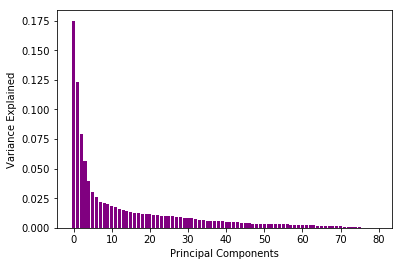

In [59]:
principal_components = len(pca_azdias.explained_variance_ratio_)
nums = np.arange(principal_components)
vals = pca_azdias.explained_variance_ratio_

plt.bar(nums, vals, color = 'purple')
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.show()

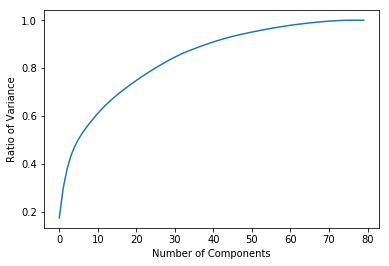

In [60]:
plt.plot(range(pca_azdias.explained_variance_ratio_.shape[0]), np.cumsum(pca_azdias.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance')
plt.show()

In [62]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_azdias_30 = PCA(n_components=30)
pca_azdias = pca_azdias_30.fit_transform(below_30_clean)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to use 30 components because looking at the graphs above, over 80% of the variance in the dataset is explained using 30 components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(pca_azdias_30, i):
    data = pd.DataFrame(pca_azdias_30.components_, columns = missing_data_below_30_columns)
    return data.iloc[i].sort_values(ascending = False)

In [67]:
map_weights(pca_azdias_30, 0)

PLZ8_ANTG3               0.196450
CAMEO_DEUG_2015          0.191076
PLZ8_ANTG4               0.190629
HH_EINKOMMEN_SCORE       0.188656
WEALTH                   0.188041
PLZ8_BAUMAX              0.186008
ORTSGR_KLS9              0.169143
EWDICHTE                 0.167246
FINANZ_HAUSBAUER         0.155018
PLZ8_ANTG2               0.134387
KBA05_ANTG4              0.133807
ZABEOTYP                 0.127934
ARBEIT                   0.122230
KBA05_ANTG3              0.120619
ANZ_HAUSHALTE_AKTIV      0.120435
RELAT_AB                 0.115605
FINANZ_SPARER            0.113633
SEMIO_PFLICHT            0.083269
SEMIO_REL                0.078968
DECADE                   0.072893
MOVEMENT                 0.072893
SEMIO_RAT                0.068877
GEBAEUDETYP              0.067480
REGIOTYP                 0.061915
SEMIO_TRADV              0.060475
GFK_URLAUBERTYP          0.058486
SEMIO_MAT                0.055830
W_KEIT_KIND_HH           0.055187
SEMIO_FAM                0.053963
FINANZ_UNAUFFA

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(pca_azdias_30, 1)

ALTERSKATEGORIE_GROB     0.253668
FINANZ_VORSORGER         0.233925
SEMIO_ERL                0.204196
SEMIO_LUST               0.177483
RETOURTYP_BK_S           0.161795
W_KEIT_KIND_HH           0.128170
FINANZTYP                0.114017
FINANZ_MINIMALIST        0.093574
FINANZ_HAUSBAUER         0.092355
SHOPPER_TYP              0.089583
SEMIO_KRIT               0.087617
SEMIO_KAEM               0.073766
PLZ8_ANTG3               0.064508
EWDICHTE                 0.063804
ORTSGR_KLS9              0.062937
PLZ8_ANTG4               0.061472
WOHNDAUER_2008           0.059632
PLZ8_BAUMAX              0.057620
ANREDE_KZ                0.055257
WEALTH                   0.053035
ARBEIT                   0.049890
CAMEO_DEUG_2015          0.048390
KBA05_ANTG4              0.048389
RELAT_AB                 0.046074
ANZ_HAUSHALTE_AKTIV      0.045986
PLZ8_ANTG2               0.044164
SEMIO_DOM                0.040339
HH_EINKOMMEN_SCORE       0.034750
KBA05_ANTG3              0.026718
ANZ_HH_TITEL  

In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(pca_azdias_30, 2)

SEMIO_VERT               0.338764
SEMIO_FAM                0.266687
SEMIO_SOZ                0.265044
SEMIO_KULT               0.257361
FINANZ_MINIMALIST        0.141920
FINANZTYP                0.105999
SEMIO_REL                0.102937
RETOURTYP_BK_S           0.086913
W_KEIT_KIND_HH           0.081421
SEMIO_MAT                0.077135
FINANZ_VORSORGER         0.069259
PLZ8_BAUMAX              0.043283
ALTERSKATEGORIE_GROB     0.040921
PLZ8_ANTG4               0.039549
PLZ8_ANTG3               0.037991
ORTSGR_KLS9              0.036209
GREEN_AVANTGARDE         0.036030
SEMIO_LUST               0.035355
LP_STATUS_GROB           0.034892
EWDICHTE                 0.034339
ARBEIT                   0.031381
CAMEO_DEUG_2015          0.027579
WEALTH                   0.027008
RELAT_AB                 0.025246
PLZ8_ANTG2               0.023622
WOHNDAUER_2008           0.022654
LP_STATUS_FEIN           0.022475
KBA05_ANTG4              0.021081
ANZ_HAUSHALTE_AKTIV      0.020377
OST_WEST_KZ   

### Discussion 2.3: Interpret Principal Components

The first component shows that PLZ8_ANTG3 (number of 6-10 family houses in the PLZ8 region) and PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region) have a positive correlation. While MOBI_REGIO (movement patterns) and PLZ8_ANTG1 (number of 1-2 family houses in the PLZ8 region) both have a negative correlation.

The second component shows ALTERSKATEGORIE_GROB (Estimated age based on given name analysis) and FINANZ_VORSORGER (financial topology) have a positive correlation. While DECADE (decades from 40s to 90s) and FINANZ_SPARER (financial topology) both have a negative correlation.

The third component shows SEMIO_VERT (personality topology) and SEMIO_KULT (personality topology) have a positive correlation. While ANREDE_KZ (gender) and SEMIO_KAEM (personality topology) both have a negative correlation.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [107]:
# Over a number of different cluster counts...
num_of_clusters = list(range(1, 20))
scores = []

for i in num_of_clusters:
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(n_clusters = i)
    model = kmeans.fit(pca_azdias)
        
    # compute the average within-cluster distances.
    score = np.abs(model.score(pca_azdias))
    scores.append(score)
    

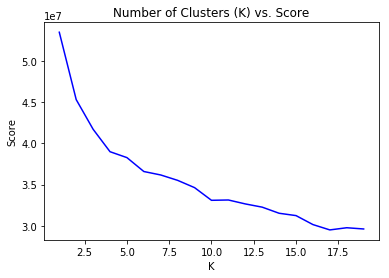

In [108]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_of_clusters, scores, color = 'blue')
plt.title('Number of Clusters (K) vs. Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

In [110]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
num_clusters = 10

kmeans = MiniBatchKMeans(num_clusters)
kmeans_model = kmeans.fit(pca_azdias)
pred_azdias = kmeans_model.predict(pca_azdias)

### Discussion 3.1: Apply Clustering to General Population

I ended up using MiniBatchKMeans since the KMeans would not run in a decent amount of time. I decided to use 6 clusters to segment the population since this is where it seems to stop sloping.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [111]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [112]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
customers_clean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,5,1,5,1,2,2,1.0,20.0,5.0,...,1.0,5.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0
2,4.0,5,1,5,1,4,4,2.0,13.0,3.0,...,3.0,3.0,2.0,3.0,5.0,3.0,2.0,2.0,3.0,4.0
3,4.0,5,1,5,2,1,2,2.0,NaN,NaN,...,1.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,3,1,4,4,5,2,3.0,31.0,10.0,...,2.0,3.0,3.0,3.0,5.0,1.0,4.0,4.0,4.0,1.0
5,3.0,5,1,5,1,2,3,3.0,17.0,5.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,2.0,3.0,4.0


In [113]:
customers_imputer = clean_nans.fit_transform(customers_clean)

customers_normalize = scaler.fit_transform(customers_imputer)

customers_pca = pca_azdias_30.fit_transform(customers_normalize)

In [114]:
customer_final = kmeans_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Pop Clusters')

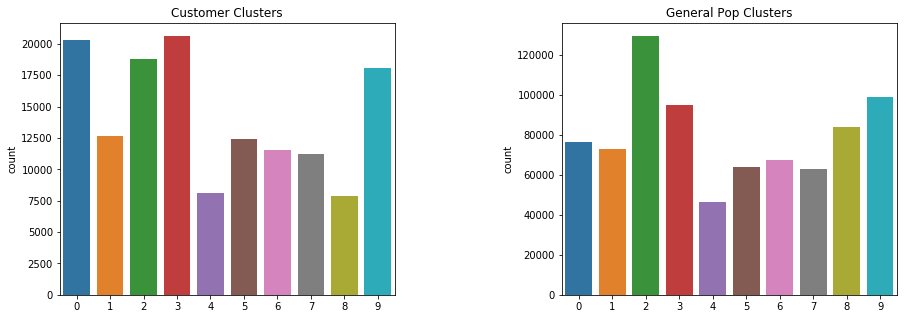

In [115]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
figure.subplots_adjust(hspace = 1, wspace = .5)

sns.countplot(customer_final, ax = axs[0])
axs[0].set_title('Customer Clusters')

sns.countplot(pred_azdias, ax = axs[1])
axs[1].set_title('General Pop Clusters')

In [118]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_3 = scaler.inverse_transform(pca_azdias_30.inverse_transform(model.cluster_centers_[3]))
overrepresented = pd.Series(data = cluster_3, index = customers_clean.columns)
overrepresented

ALTERSKATEGORIE_GROB        4.539173
FINANZ_MINIMALIST           5.525486
FINANZ_SPARER               0.223859
FINANZ_VORSORGER            5.742592
FINANZ_ANLEGER              0.471388
FINANZ_UNAUFFAELLIGER       0.845929
FINANZ_HAUSBAUER            2.534778
HEALTH_TYP                  1.282439
LP_LEBENSPHASE_FEIN        30.675240
LP_LEBENSPHASE_GROB         9.116450
RETOURTYP_BK_S              4.573406
SEMIO_SOZ                   5.013361
SEMIO_FAM                   4.854154
SEMIO_REL                   3.010306
SEMIO_MAT                   3.762794
SEMIO_VERT                  7.473845
SEMIO_LUST                  7.337345
SEMIO_ERL                   4.207607
SEMIO_KULT                  4.872027
SEMIO_RAT                   1.097741
SEMIO_KRIT                  1.771611
SEMIO_DOM                   1.531339
SEMIO_KAEM                  1.016224
SEMIO_PFLICHT               1.431260
SEMIO_TRADV                 2.174372
ANZ_PERSONEN                2.680810
ANZ_TITEL                   0.046333
H

In [119]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_8 = scaler.inverse_transform(pca_azdias_30.inverse_transform(model.cluster_centers_[8]))
underrepresented = pd.Series(data = cluster_8, index = customers_clean.columns)
underrepresented

ALTERSKATEGORIE_GROB        2.602451
FINANZ_MINIMALIST           4.407091
FINANZ_SPARER               2.272669
FINANZ_VORSORGER            3.673585
FINANZ_ANLEGER              2.605666
FINANZ_UNAUFFAELLIGER       2.846612
FINANZ_HAUSBAUER            1.523631
HEALTH_TYP                  2.434177
LP_LEBENSPHASE_FEIN        25.310044
LP_LEBENSPHASE_GROB         7.450812
RETOURTYP_BK_S              3.583539
SEMIO_SOZ                   3.702902
SEMIO_FAM                   3.623276
SEMIO_REL                   3.984488
SEMIO_MAT                   3.692275
SEMIO_VERT                  4.149798
SEMIO_LUST                  4.052717
SEMIO_ERL                   4.662386
SEMIO_KULT                  3.925229
SEMIO_RAT                   4.447230
SEMIO_KRIT                  4.796170
SEMIO_DOM                   5.202873
SEMIO_KAEM                  4.571340
SEMIO_PFLICHT               4.533828
SEMIO_TRADV                 4.080470
ANZ_PERSONEN                2.315085
ANZ_TITEL                  -0.006929
H

### Discussion 3.3: Compare Customer Data to Demographics Data

After all my analysis, you can see the following in the graphs above:

Cluster 3 is overrepresented in the customer data compared to the general population data.
- ALTERSKATEGORIE_GROB 4.539173: The age is over 60 years old.
- BALLRAUM 5.490701: The distance to the nearest urban center is 40 - 50 km.
- LP_LEBENSPHASE_FEIN 30.675240: The life stage at a fine scale is average earners of younger age from multiperson households.
- INNENSTADT 5.490701: The distance to the city center is 10 – 20 km.
- HH_EINKOMMEN_SCORE 2.517611: The estimated household income is very high. 

Cluster 4 is underrepresented in the customer data compared to the general population data.
- ALTERSKATEGORIE_GROB 2.602451: The age is around 30 - 45 years old.
- BALLRAUM 4.627674: The distance to the nearest urban center is 30 - 40 km.
- LP_LEBENSPHASE_FEIN 25.310044: The life stage at a fine scale is average earner families.
- INNENSTADT 5.392101: The distance to the city center is 10 – 20 km.
- HH_EINKOMMEN_SCORE 2.136633: The estimated household income is very high. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.